In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split
import itertools
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import pickle
import torch, torch.optim as optim, contextlib, gc
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)  # fix random numbers

In [3]:
torch.cuda.is_available()

True

In [4]:
 # try to set device to GPU if CUDA is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

# Read and preprocess data

In [6]:
data = pd.read_csv('../data/multi-yield_training_data.csv')

## Basic statistics

In [7]:
data.head()

,$A_{00}$,$A_{01}$,$A_{10}$,$A_{11}$,$P_{1}^{0}{}_{00}$,$P_{1}^{0}{}_{01}$,$P_{1}^{0}{}_{10}$,$P_{1}^{0}{}_{11}$,$P_{2}^{0}{}_{00}$,$P_{2}^{0}{}_{01}$,$P_{2}^{0}{}_{10}$,$P_{2}^{0}{}_{11}$,"$P_{1\,00}$","$P_{1\,01}$","$P_{1\,10}$","$P_{1\,11}$","$P_{2\,00}$","$P_{2\,01}$","$P_{2\,10}$","$P_{2\,11}$"
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.729700e+07,1.979706e+05,1.979706e+05,1.562848e+08,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
2,1.345940e+08,7.918822e+05,7.918822e+05,3.125695e+08,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
3,2.018910e+08,1.781735e+06,1.781735e+06,4.688543e+08,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
4,2.691880e+08,3.167529e+06,3.167529e+06,6.251390e+08,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405000 entries, 0 to 404999
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   $A_{00}$            405000 non-null  float64
 1   $A_{01}$            405000 non-null  float64
 2   $A_{10}$            405000 non-null  float64
 3   $A_{11}$            405000 non-null  float64
 4   $P_{1}^{0}{}_{00}$  405000 non-null  float64
 5   $P_{1}^{0}{}_{01}$  405000 non-null  float64
 6   $P_{1}^{0}{}_{10}$  405000 non-null  float64
 7   $P_{1}^{0}{}_{11}$  405000 non-null  float64
 8   $P_{2}^{0}{}_{00}$  405000 non-null  float64
 9   $P_{2}^{0}{}_{01}$  405000 non-null  float64
 10  $P_{2}^{0}{}_{10}$  405000 non-null  float64
 11  $P_{2}^{0}{}_{11}$  405000 non-null  float64
 12  $P_{1\,00}$         405000 non-null  float64
 13  $P_{1\,01}$         405000 non-null  float64
 14  $P_{1\,10}$         405000 non-null  float64
 15  $P_{1\,11}$         405000 non-nul

In [9]:
data.describe()

,$A_{00}$,$A_{01}$,$A_{10}$,$A_{11}$,$P_{1}^{0}{}_{00}$,$P_{1}^{0}{}_{01}$,$P_{1}^{0}{}_{10}$,$P_{1}^{0}{}_{11}$,$P_{2}^{0}{}_{00}$,$P_{2}^{0}{}_{01}$,$P_{2}^{0}{}_{10}$,$P_{2}^{0}{}_{11}$,"$P_{1\,00}$","$P_{1\,01}$","$P_{1\,10}$","$P_{1\,11}$","$P_{2\,00}$","$P_{2\,01}$","$P_{2\,10}$","$P_{2\,11}$"
count,4.050000e+05,4.050000e+05,4.050000e+05,4.050000e+05,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000
mean,1.707500e+11,6.336300e+10,6.336300e+10,1.307500e+11,0.000915,0.002792,0.002792,-0.000915,0.082450,0.255138,0.255138,-0.082450,0.060714,0.192240,0.192240,-0.060714,0.022651,0.065690,0.065690,-0.022651
std,1.362263e+11,4.810844e+10,4.810844e+10,8.570968e+10,0.001293,0.001843,0.001843,0.001293,0.143009,0.275037,0.275037,0.143009,0.096279,0.176169,0.176169,0.096279,0.062724,0.128906,0.128906,0.062724
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.002378,0.000000,0.000000,-0.003216,-0.206053,0.000000,0.000000,-0.649490,-0.137830,0.000000,0.000000,-0.307128,-0.098867,0.000000,0.000000,-0.404345
25%,6.003946e+10,2.091836e+10,2.091836e+10,6.032002e+10,0.000000,0.000000,0.000000,-0.002173,0.000000,0.000000,0.000000,-0.142979,0.000000,0.000000,0.000000,-0.126961,0.000000,0.000000,0.000000,-0.000000
50%,1.349900e+11,5.021009e+10,5.021009e+10,1.207683e+11,0.000483,0.003719,0.003719,-0.000483,0.012095,0.154727,0.154727,-0.012095,0.012875,0.158579,0.158579,-0.012875,-0.000000,0.000000,0.000000,-0.000000
75%,2.544760e+11,1.001582e+11,1.001582e+11,1.887175e+11,0.002173,0.004262,0.004262,0.000000,0.142979,0.459290,0.459290,0.000000,0.126961,0.379761,0.379761,0.000000,0.000000,0.055141,0.055141,0.000000
max,6.225000e+11,1.800000e+11,1.800000e+11,3.825000e+11,0.003216,0.004419,0.004419,0.002378,0.649490,0.974236,0.974236,0.206053,0.307128,0.446361,0.446361,0.137830,0.404345,0.606518,0.606518,0.098867


In [10]:
display(data.shape)

(405000, 20)

## Visualize data

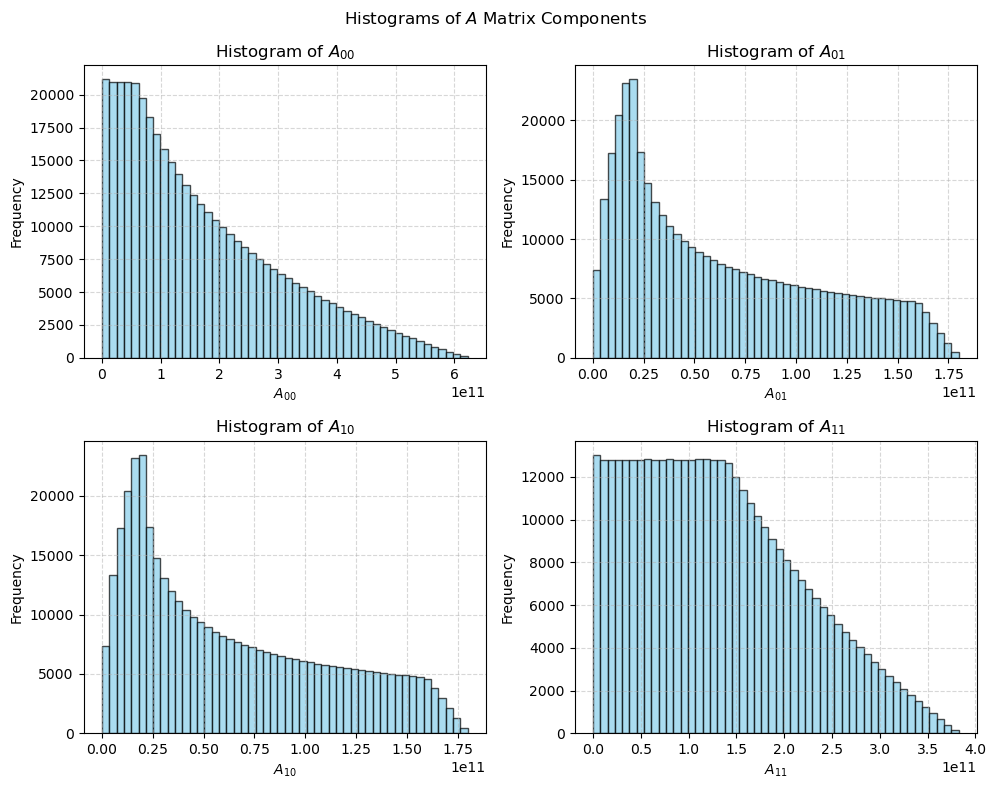

In [11]:
# Select columns related to matrix A
A_columns = [col for col in data.columns if col.startswith("$A_")]
data_A = data[A_columns]

# Define number of rows and columns for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot histograms
for i, col in enumerate(A_columns):
    row, col_idx = divmod(i, 2)  # Compute subplot position
    ax = axes[row, col_idx]
    ax.hist(data_A[col], bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

# Adjust layout
plt.suptitle("Histograms of $A$ Matrix Components")
plt.tight_layout()
# uncomment/comment to save/ not to save
#plt.savefig("../images/multi-yield/A_histograms.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()


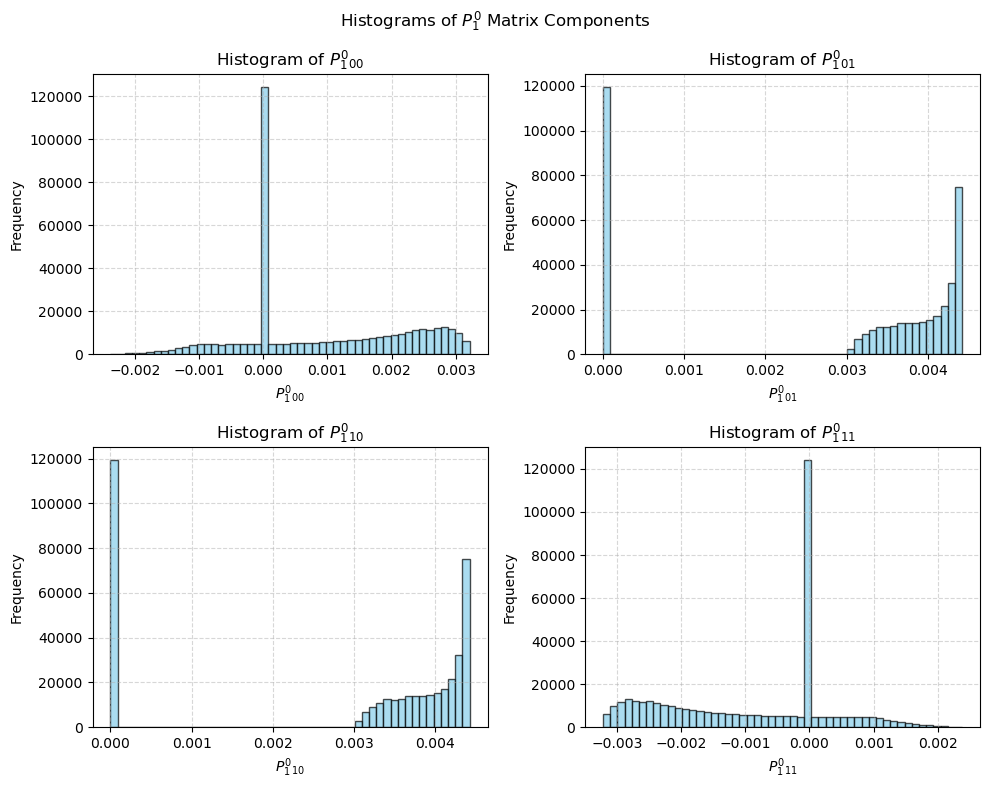

In [12]:
# Select columns related to matrix P1_init
P1_init_columns = [col for col in data.columns if col.startswith("$P_{1}^{0}")]
data_P1_init = data[P1_init_columns]

# Define number of rows and columns for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot histograms
for i, col in enumerate(P1_init_columns):
    row, col_idx = divmod(i, 2)  # Compute subplot position
    ax = axes[row, col_idx]
    ax.hist(data_P1_init[col], bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

# Adjust layout
plt.suptitle("Histograms of $P_{1}^{0}$ Matrix Components")
plt.tight_layout()
# uncomment/comment to save/ not to save
#plt.savefig("../images/multi-yield/P1_init_histograms.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

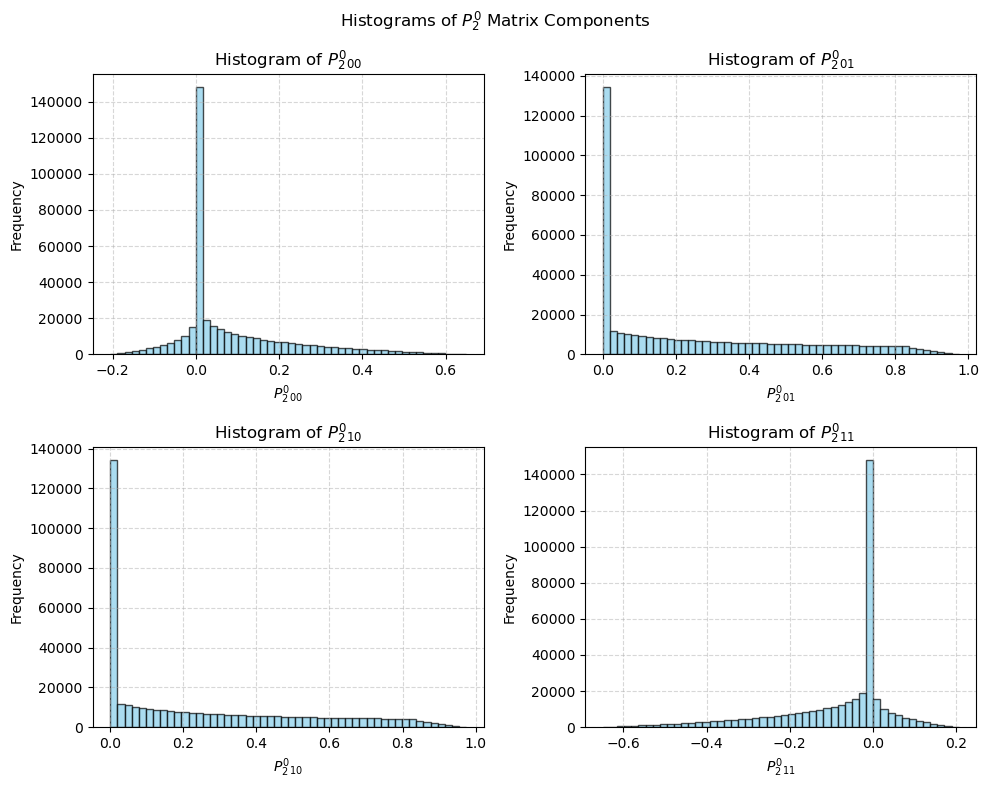

In [13]:
# Select columns related to matrix P2_init
P2_init_columns = [col for col in data.columns if col.startswith("$P_{2}^{0}")]
data_P2_init = data[P2_init_columns]

# Define number of rows and columns for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot histograms
for i, col in enumerate(P2_init_columns):
    row, col_idx = divmod(i, 2)  # Compute subplot position
    ax = axes[row, col_idx]
    ax.hist(data_P2_init[col], bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

# Adjust layout
plt.suptitle("Histograms of $P_{2}^{0}$ Matrix Components")
plt.tight_layout()
# uncomment/comment to save/ not to save
#plt.savefig("../images/multi-yield/P2_init_histograms.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

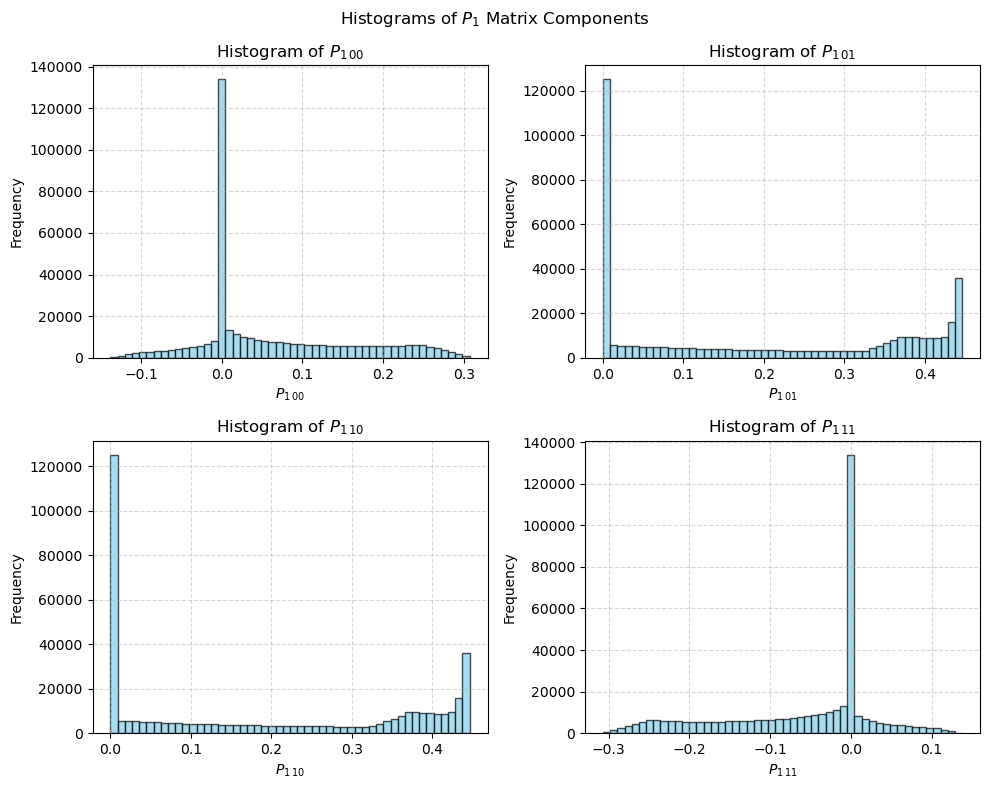

In [14]:
# Select columns related to matrix P1
P1_columns = [col for col in data.columns if col.startswith(r"$P_{1\,")]
data_P1 = data[P1_columns]

# Define number of rows and columns for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot histograms
for i, col in enumerate(P1_columns):
    row, col_idx = divmod(i, 2)  # Compute subplot position
    ax = axes[row, col_idx]
    ax.hist(data_P1[col], bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(rf"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

# Adjust layout
plt.suptitle("Histograms of $P_1$ Matrix Components")
plt.tight_layout()
# uncomment/comment to save/ not to save
#plt.savefig("../images/multi-yield/P1_histograms.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

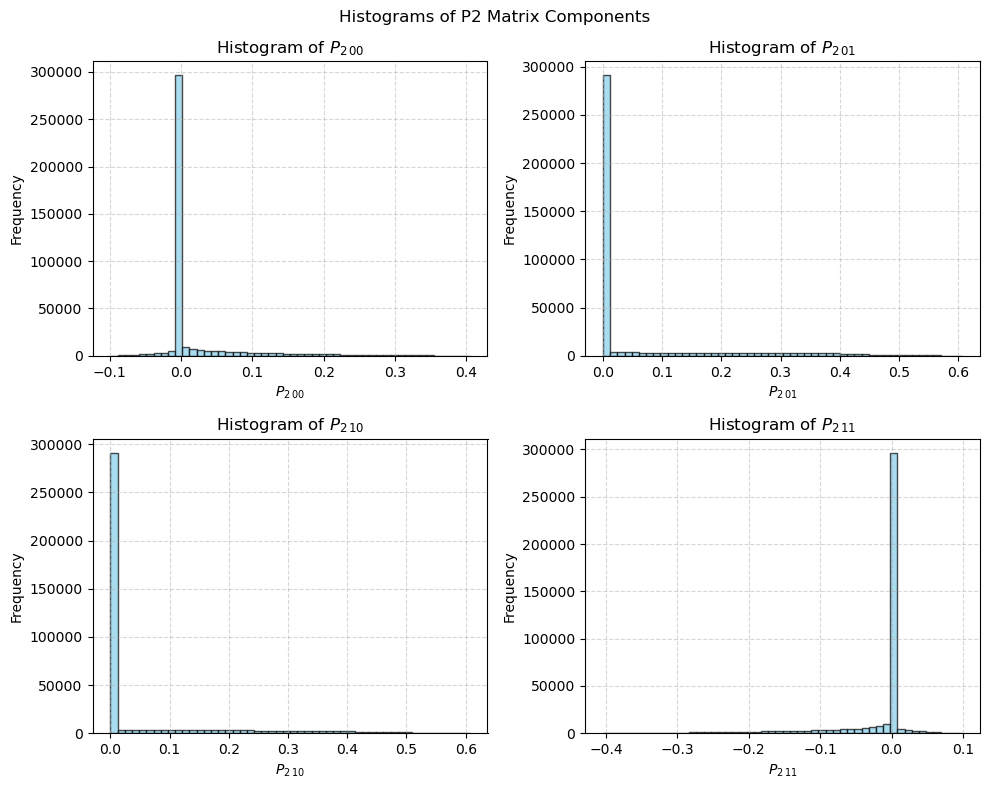

In [15]:
# Select columns related to matrix P2_init
P2_columns = [col for col in data.columns if col.startswith(r"$P_{2\,")]
data_P2 = data[P2_columns]

# Define number of rows and columns for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot histograms
for i, col in enumerate(P2_columns):
    row, col_idx = divmod(i, 2)  # Compute subplot position
    ax = axes[row, col_idx]
    ax.hist(data_P2[col], bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

# Adjust layout
plt.suptitle("Histograms of P2 Matrix Components")
plt.tight_layout()
# uncomment/comment to save/ not to save
#plt.savefig("../images/multi-yield/P2_histograms.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

- As we can see from statistics and visualizations tensors A, P1_init, P2_init, P1, P2 are symmetric. P1_init, P2_init, P1, P2 also have zero trace. So I will delete duplicate, non-significant data.

## Transform data

In [16]:
# delete A_10, P1^0_10, P1^0_11 P2^0_10, P2^0_11, P1_10, P1_11, P2_10, P2_11 columns
data.drop(['$A_{10}$', '$P_{1}^{0}{}_{10}$', '$P_{1}^{0}{}_{11}$', '$P_{2}^{0}{}_{10}$', '$P_{2}^{0}{}_{11}$', r'$P_{1\,10}$', r'$P_{1\,11}$', r'$P_{2\,10}$', r'$P_{2\,11}$'], axis=1, inplace=True)

In [17]:
data.head()

,$A_{00}$,$A_{01}$,$A_{11}$,$P_{1}^{0}{}_{00}$,$P_{1}^{0}{}_{01}$,$P_{2}^{0}{}_{00}$,$P_{2}^{0}{}_{01}$,"$P_{1\,00}$","$P_{1\,01}$","$P_{2\,00}$","$P_{2\,01}$"
0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.729700e+07,1.979706e+05,1.562848e+08,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
2,1.345940e+08,7.918822e+05,3.125695e+08,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
3,2.018910e+08,1.781735e+06,4.688543e+08,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
4,2.691880e+08,3.167529e+06,6.251390e+08,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405000 entries, 0 to 404999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   $A_{00}$            405000 non-null  float64
 1   $A_{01}$            405000 non-null  float64
 2   $A_{11}$            405000 non-null  float64
 3   $P_{1}^{0}{}_{00}$  405000 non-null  float64
 4   $P_{1}^{0}{}_{01}$  405000 non-null  float64
 5   $P_{2}^{0}{}_{00}$  405000 non-null  float64
 6   $P_{2}^{0}{}_{01}$  405000 non-null  float64
 7   $P_{1\,00}$         405000 non-null  float64
 8   $P_{1\,01}$         405000 non-null  float64
 9   $P_{2\,00}$         405000 non-null  float64
 10  $P_{2\,01}$         405000 non-null  float64
dtypes: float64(11)
memory usage: 34.0 MB


In [19]:
data.describe()

,$A_{00}$,$A_{01}$,$A_{11}$,$P_{1}^{0}{}_{00}$,$P_{1}^{0}{}_{01}$,$P_{2}^{0}{}_{00}$,$P_{2}^{0}{}_{01}$,"$P_{1\,00}$","$P_{1\,01}$","$P_{2\,00}$","$P_{2\,01}$"
count,4.050000e+05,4.050000e+05,4.050000e+05,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000,405000.000000
mean,1.707500e+11,6.336300e+10,1.307500e+11,0.000915,0.002792,0.082450,0.255138,0.060714,0.192240,0.022651,0.065690
std,1.362263e+11,4.810844e+10,8.570968e+10,0.001293,0.001843,0.143009,0.275037,0.096279,0.176169,0.062724,0.128906
min,0.000000e+00,0.000000e+00,0.000000e+00,-0.002378,0.000000,-0.206053,0.000000,-0.137830,0.000000,-0.098867,0.000000
25%,6.003946e+10,2.091836e+10,6.032002e+10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.349900e+11,5.021009e+10,1.207683e+11,0.000483,0.003719,0.012095,0.154727,0.012875,0.158579,-0.000000,0.000000
75%,2.544760e+11,1.001582e+11,1.887175e+11,0.002173,0.004262,0.142979,0.459290,0.126961,0.379761,0.000000,0.055141
max,6.225000e+11,1.800000e+11,3.825000e+11,0.003216,0.004419,0.649490,0.974236,0.307128,0.446361,0.404345,0.606518


In [20]:
# Apply log1p only to A_ variables (avoid P1_init and P2_init)
log_A = np.log1p(data[[col for col in data.columns if col.startswith("$A_")]])

In [21]:
# Split P data
P_init_cols = [col for col in data.columns if col.startswith("$P_{1}") or col.startswith("$P_{2}")]
P_target_cols = [col for col in data.columns if col.startswith(r"$P_{1\,") or col.startswith(r"$P_{2\,")]

In [22]:
print(P_init_cols)

['$P_{1}^{0}{}_{00}$', '$P_{1}^{0}{}_{01}$', '$P_{2}^{0}{}_{00}$', '$P_{2}^{0}{}_{01}$']


In [23]:
print(P_target_cols)

['$P_{1\\,00}$', '$P_{1\\,01}$', '$P_{2\\,00}$', '$P_{2\\,01}$']


In [24]:
# Scalers
A_scaler = StandardScaler()
P_init_scaler = RobustScaler()
P_target_scaler = RobustScaler()

In [25]:
A_standardized = A_scaler.fit_transform(log_A)
P_init_scaled_array = P_init_scaler.fit_transform(data[P_init_cols])
P_init_scaled = pd.DataFrame(P_init_scaled_array, columns=P_init_cols, index=data.index)
P_target_scaled_array = P_target_scaler.fit_transform(data[P_target_cols])
P_target_scaled = pd.DataFrame(P_target_scaled_array, columns=P_target_cols, index=data.index)

## Visualize after transformation

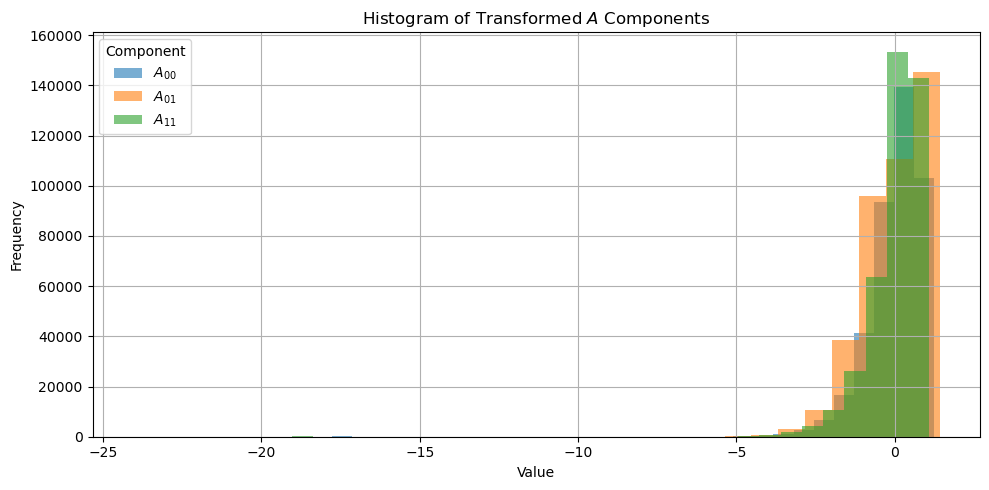

In [26]:
component_labels = ["A_{00}", "A_{01}", "A_{11}"]

plt.figure(figsize=(10, 5))
for i in range(A_standardized.shape[1]):
    plt.hist(A_standardized[:, i], bins=30, alpha=0.6, label=f"${component_labels[i]}$")

plt.title("Histogram of Transformed $A$ Components")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(title="Component")
plt.grid(True)
plt.tight_layout()
# uncomment/comment to save/not to save
#plt.savefig("../images/multi-yield/A_transformed.png", format='png', dpi = 300, bbox_inches="tight")
plt.show()

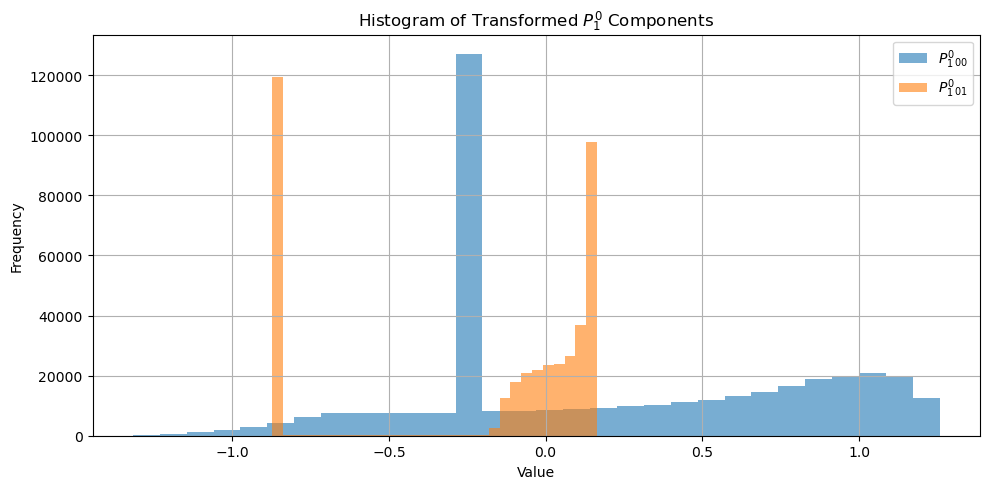

In [27]:
# P1_init
component_labels = ["P_{1}^{0}{}_{00}", "P_{1}^{0}{}_{01}"]

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.hist(P_init_scaled_array[:, i], bins=30, alpha=0.6, label=rf"${component_labels[i]}$")
plt.title("Histogram of Transformed $P_1^0$ Components")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
# uncomment/comment to save/not to save
#plt.savefig("../images/multi-yield/P1_init_transformed.png", format='png', dpi = 300, bbox_inches="tight")
plt.show()

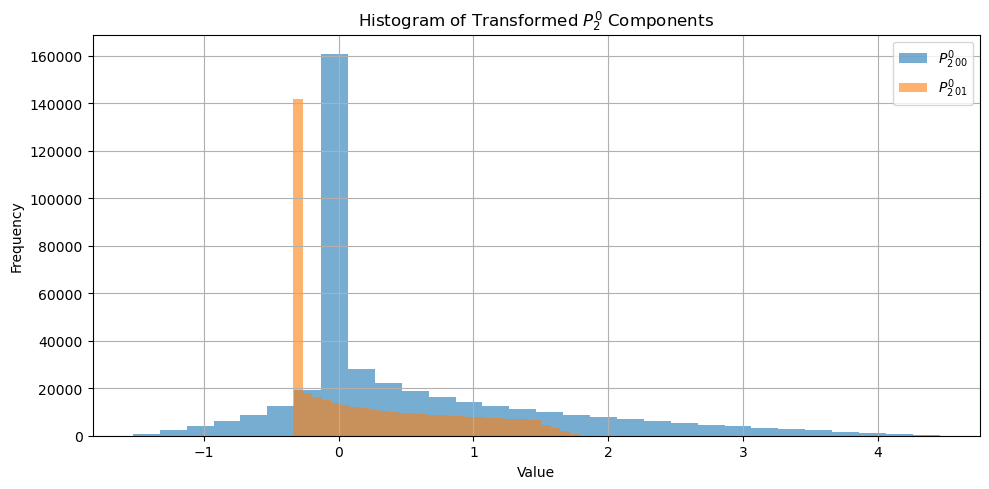

In [28]:
# P2_init
component_labels = ["P_{2}^{0}{}_{00}", "P_{2}^{0}{}_{01}"]

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.hist(P_init_scaled_array[:, i+2], bins=30, alpha=0.6, label=rf"${component_labels[i]}$")
plt.title("Histogram of Transformed $P_2^0$ Components")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
# uncomment/comment to save/not to save
#plt.savefig("../images/multi-yield/P2_init_transformed.png", format='png', dpi = 300, bbox_inches="tight")
plt.show()

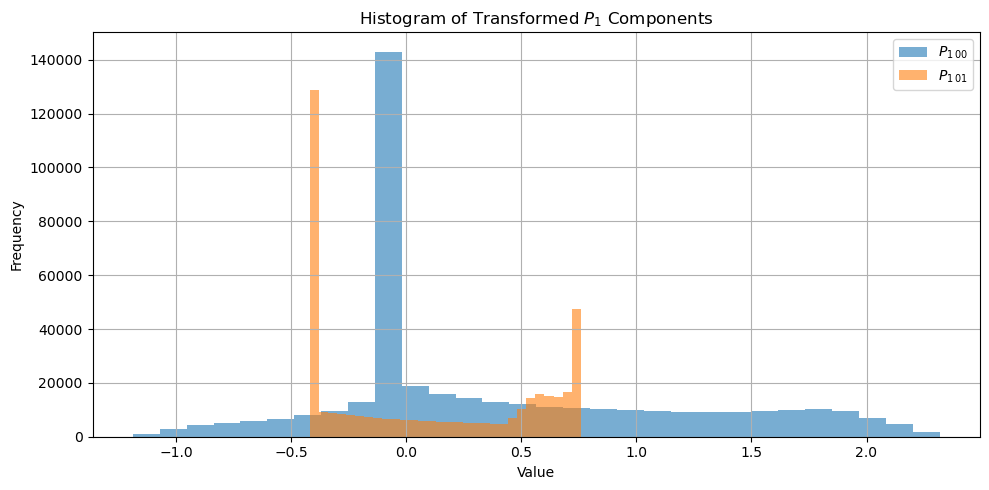

In [29]:
# P1
component_labels = ["P_{1\\,00}", "P_{1\\,01}"]

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.hist(P_target_scaled_array[:, i], bins=30, alpha=0.6, label=rf"${component_labels[i]}$")
plt.title("Histogram of Transformed $P_1$ Components")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
# uncomment/comment to save/not to save
#plt.savefig("../images/multi-yield/P1_transformed.png", format='png', dpi = 300, bbox_inches="tight")
plt.show()

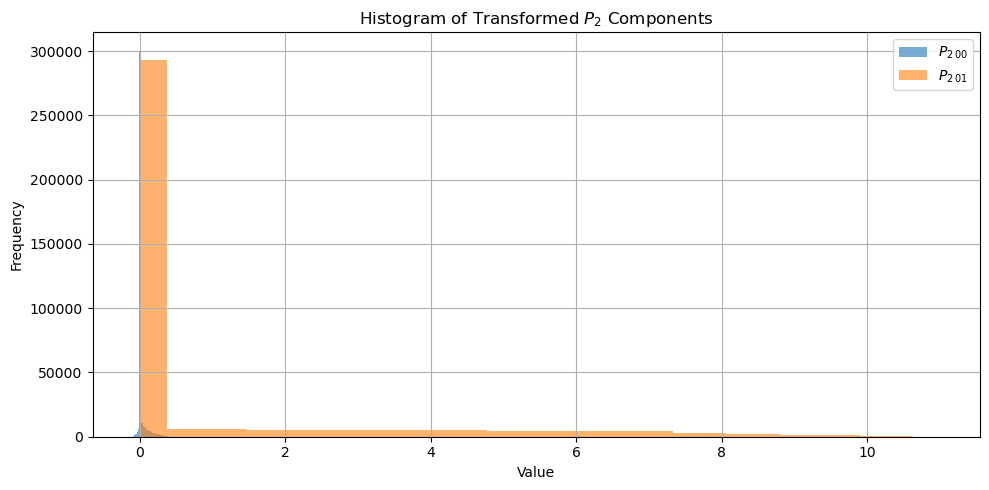

In [30]:
# P2
component_labels = ["P_{2\\,00}", "P_{2\\,01}"]

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.hist(P_target_scaled_array[:, i+2], bins=30, alpha=0.6, label=rf"${component_labels[i]}$")
plt.title("Histogram of Transformed $P_2$ Components")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
# uncomment/comment to save/not to save
#plt.savefig("../images/multi-yield/P2_transformed.png", format='png', dpi = 300, bbox_inches="tight")
plt.show()

## Create trensors for NN

In [19]:
# Save Scaler
joblib.dump(A_scaler, 'multi-yield_scaler_A.pkl')
joblib.dump(P_init_scaler, 'multi-yield_scaler_P_init.pkl')
joblib.dump(P_target_scaler, 'multi-yield_scaler_P_target.pkl')

['multi-yield_scaler_P_target_combined.pkl']

In [20]:
# input (X): A + P1_init + P2_init
X = np.hstack([A_standardized, P_init_scaled])

In [21]:
# output (y): P1 + P2
y = P_target_scaled

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32, device=device)

# Neural Network

In [24]:
class DynamicMLP(nn.Module):
    """
    Multilayer perceptron (MLP) with dynamic layer configuration and optional Dropout regularisation.

    This class allows the creation of MLPs with an arbitrary number of layers and neurons, and with the ability to
    adding Dropout between layers to prevent overtraining.

    Args:
        layers (list): A list containing the number of neurons in each layer. The length of the list determines
                       the number of layers; the list values are the number of neurons in each corresponding layer.
        dropout_rate (float, optional): The probability of neurons in Dropout layers being switched off.
                                        The default is 0, which means no Dropout.
    """
    def __init__(self, layers, dropout_rate=0):
        super(DynamicMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout_rate = dropout_rate

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:  # no activation function after last layer
                self.layers.append(nn.ReLU())  # Reduced linear unit
                if self.dropout_rate != 0:
                    self.layers.append(nn.Dropout(self.dropout_rate))

    def forward(self, x):
        """
        Forward pass of the MLP model.

        This method propagates the input `x` through the network layers, applying
        linear transformations, ReLU activations (except for the last layer), and
        optional dropout regularization.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim).
        """
        x = x.flatten(start_dim=1)
        for layer in self.layers:
            x = layer(x)
        return x

In [32]:
# parameters
layer_configs = [
    [7, 256, 128, 4],                # 35k params
    [7, 512, 256, 128, 4],           # 168k
    [7, 256, 512, 256, 4],           # 265k
]
dropout_rates = [0, 0.1, 0.33]
optimizers = ['adam', 'sgd']
learning_rates = [1e-5, 1e-4, 1e-3]
weight_decays = [1e-5, 1e-4, 1e-3]
deltas =  [0.5, 1.0, 1.5]

In [33]:
# Combinations list
grid_full = list(itertools.product(layer_configs, dropout_rates, optimizers, learning_rates, weight_decays, deltas))

In [34]:
# --- random sub‑grid of size N ----------------------------------
N = 50                                   # how many configs you want
rnd = random.Random(42)                  # fixed seed = reproducible
grid = rnd.sample(grid_full, k=min(N, len(grid_full)))

In [35]:
# Early stopping function
class EarlyStopping:
    """
    Implements early stopping to halt training when validation loss stops improving.

    Attributes:
    - patience (int): Number of epochs to wait after the last improvement before stopping.
    - delta (float): Minimum change in the monitored value to qualify as an improvement.
    - best_loss (float or None): Tracks the best recorded validation loss.
    - counter (int): Counts the number of epochs since the last improvement.
    - early_stop (bool): Indicates whether training should be stopped.

    Methods:
    - __call__(val_loss): Updates the tracking variables and determines whether to stop training.
    """

    def __init__(self, patience=5, delta=0):
        """
        Initializes the early stopping mechanism.

        Args:
        - patience (int): Number of epochs to wait before stopping if no improvement is detected.
        - delta (float): Minimum required decrease in loss to reset the patience counter.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Checks whether validation loss has improved and updates internal state.

        Args:
        - val_loss (float): The current validation loss.

        If the validation loss has not improved for `patience` epochs, sets `early_stop` to True.
        """
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [36]:
class HuberLoss(nn.Module):
    def __init__(self, delta=0.5):
        """
        Standard Huber Loss without any additional weighting.

        Args:
            delta (float): Threshold between quadratic and linear regions.
        """
        super().__init__()
        self.delta = delta

    def forward(self, pred, target):
        error = pred - target
        abs_error = torch.abs(error)

        loss = torch.where(
            abs_error < self.delta,
            0.5 * error ** 2,         # MSE region
            self.delta * (abs_error - 0.5 * self.delta)  # MAE region
        )

        return loss.mean()

In [37]:
def train_model(
    grid,
    model_class,
    loss_class,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    *,
    batch_size = 4096,   # tune to your GPU
    epochs     = 100,
    patience   = 10,
    delta      = 1e-4,
):
    # ------------------------------------------------------------------
    # 1.  Device & AMP helpers
    # ------------------------------------------------------------------
    device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_amp  = device.type == "cuda"
    autocast = torch.cuda.amp.autocast if use_amp else contextlib.nullcontext
    print(f"Using device: {device}")

    # ------------------------------------------------------------------
    # 2.  Push tensors to that device
    # ------------------------------------------------------------------
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    X_val_tensor   = X_val_tensor.to(device)
    y_val_tensor   = y_val_tensor.to(device)

    # ------------------------------------------------------------------
    # 3.  DataLoaders (no shuffle ⇒ randperm‑on‑GPU problem avoided)
    # ------------------------------------------------------------------
    train_dl = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size = batch_size,
        shuffle    = False,     # already random enough if data were pre‑shuffled
        num_workers= 0,
        pin_memory = False,     # tensors already on GPU/CPU target
    )
    val_dl = DataLoader(
        TensorDataset(X_val_tensor, y_val_tensor),
        batch_size = batch_size,
        shuffle    = False,
        num_workers= 0,
        pin_memory = False,
    )

    # ------------------------------------------------------------------
    # 4.  Grid search
    # ------------------------------------------------------------------
    best_state, best_cfg = None, None
    global_best_val      = float("inf")

    for layers, dropout, opt_name, lr, weight_decay, delta_val in grid:
        print(f"\nCFG  layers={layers}  drop={dropout}  opt={opt_name}"
              f"  lr={lr}  wd={weight_decay}  δ={delta_val}")

        model = model_class(layers, dropout_rate=dropout).to(device)
        criterion = loss_class(delta=delta_val).to(device)

        optimizer = (optim.Adam if opt_name == "adam" else optim.SGD)(
            model.parameters(),
            lr           = lr,
            weight_decay = weight_decay,
            **({'momentum': 0.9} if opt_name == "sgd" else {})
        )
        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

        best_val, strikes, local_best = float("inf"), 0, None

        # ------------------- epochs -------------------
        for epoch in range(epochs):
            # ---- training ----
            model.train()
            for xb, yb in train_dl:
                optimizer.zero_grad(set_to_none=True)
                with autocast():
                    pred  = model(xb)
                    loss  = criterion(pred, yb)
                if use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

            # ---- validation ----
            model.eval()
            val_sum = 0.0
            with torch.no_grad(), autocast():
                for xb, yb in val_dl:
                    val_sum += criterion(model(xb), yb).item() * xb.size(0)
            val_loss = val_sum / len(val_dl.dataset)

            # ---- early stopping ----
            if val_loss + delta < best_val:
                best_val   = val_loss
                local_best = model.state_dict()
                strikes    = 0
            else:
                strikes += 1
                if strikes >= patience:
                    print(f"  early‑stop @ epoch {epoch}")
                    break

        # ---- keep global best ----
        if best_val < global_best_val:
            global_best_val = best_val
            best_state      = local_best
            best_cfg = {
                "layers": layers, "dropout": dropout,
                "optimizer": opt_name, "lr": lr,
                "weight_decay": weight_decay,
                "delta": delta_val, "val_loss": best_val,
            }

        # ---- clean up ----
        del model, optimizer, criterion, scaler, local_best
        if use_amp:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
        gc.collect()

    return best_state, best_cfg, global_best_val

In [38]:
# Execute the training function
best_model_state, best_config, best_val_loss = train_model(
    grid=grid,
    model_class=DynamicMLP,
    loss_class=HuberLoss,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,
    y_val_tensor=y_val_tensor,
    epochs=200,
    patience=10,
    delta=1e-3
)

Using device: cuda

CFG  layers=[7, 256, 512, 256, 4]  drop=0  opt=adam  lr=1e-05  wd=0.0001  δ=0.5


/tmp/ipykernel_10365/1813585523.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_10365/1813585523.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_10365/1813585523.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


  early‑stop @ epoch 17

CFG  layers=[7, 256, 128, 4]  drop=0.1  opt=adam  lr=1e-05  wd=0.0001  δ=0.5
  early‑stop @ epoch 36

CFG  layers=[7, 256, 128, 4]  drop=0  opt=adam  lr=0.0001  wd=0.0001  δ=0.5
  early‑stop @ epoch 12

CFG  layers=[7, 256, 512, 256, 4]  drop=0.1  opt=adam  lr=1e-05  wd=1e-05  δ=1.0
  early‑stop @ epoch 18

CFG  layers=[7, 256, 128, 4]  drop=0.33  opt=sgd  lr=1e-05  wd=0.0001  δ=1.5

CFG  layers=[7, 256, 128, 4]  drop=0.33  opt=adam  lr=0.0001  wd=0.001  δ=1.5
  early‑stop @ epoch 20

CFG  layers=[7, 256, 128, 4]  drop=0.33  opt=adam  lr=1e-05  wd=0.001  δ=0.5
  early‑stop @ epoch 42

CFG  layers=[7, 256, 128, 4]  drop=0.1  opt=adam  lr=0.0001  wd=0.001  δ=1.5
  early‑stop @ epoch 16

CFG  layers=[7, 256, 512, 256, 4]  drop=0  opt=sgd  lr=0.001  wd=0.001  δ=1.5
  early‑stop @ epoch 37

CFG  layers=[7, 256, 128, 4]  drop=0  opt=sgd  lr=0.001  wd=0.001  δ=1.0
  early‑stop @ epoch 43

CFG  layers=[7, 256, 512, 256, 4]  drop=0  opt=adam  lr=0.001  wd=0.0001  δ=1.0


In [39]:
# Save the best model weights and configuration
with open("multi-yield_best_model.pkl", "wb") as f:
    pickle.dump({"model_state": best_model_state, "config": best_config}, f)

print(f"Best model saved with val_loss: {best_val_loss:.4f}")
print("Best configuration:", best_config)

Best model saved with val_loss: 0.0001
Best configuration: {'layers': [7, 512, 256, 128, 4], 'dropout': 0, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0001, 'delta': 0.5, 'val_loss': 7.969989274084655e-05}
